# 04wk-1: (신경망) – 로지스틱의 한계 극복

## 1. imports

In [1]:
import torch
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

## Extraction

`-` 렐루와 시그모이드를 이용하여 꺾인 그래프를 만들기

In [ ]:
## 1. 처음부터 다 구현하기
from copy import deepcopy
x = torch.linspace(-1.0, 1.0, 1001).reshape(-1, 1) ## (n, 1) 벡터
y = deepcopy(x) ## (n, 1) 벡터
y[x < 0] = 9*x[x < 0] + 4.5
y[x > 0] = -4.5*x[x < 0] + 4.5
yhat = 1/(1+torch.exp(-y))

## 2. 렐루만 사용하기
x = torch.linspace(-1.0, 1.0, 1001).reshape(-1, 1)

relu = torch.nn.ReLU()

relu(x) ## ┛ 이렇게 꺾임
relu(-x)    ## ㄴ 이렇게 꺾임

y = -9*relu(-x) - 4.5*relu(x) + 4.5
yhat = 1/(1+torch.exp(-y))

## 3. 렐루의 브로드캐스팅을 활용하여 벡터로 연산
x = torch.linspace(-1.0, 1.0, 1001).reshape(-1, 1)
u = torch.concat([x, -x], axis = 1) ## 이 경우, X@[1 -1]과 동일함

relu = torch.nn.ReLU()

v = relu(u) ## 각 열에 브로드캐스팅

y = -4.5*v[:, [0]] - 9.0*v[:, [1]] + 4.5    ## 각 열을 선형결합
yhat = 1/(1+torch.exp(-y))

## 4. torch.nn.Linear()를 이용하여 선형 변환
x = torch.linspace(-1.0, 1.0, 1001).reshape(-1, 1)
l1 = torch.nn.Linear(1, 2, bias = False)    ## 여긴 일단은 처음에 행렬만 곱해주므로 false 처리
l1.weight.data = torch.tensor([[1.0],
                               [-1.0]]) ## 원래 행벡터를 곱해줘야 하지만, 얘는 알고리즘이 공학적 이유로 거꾸로 써줘야 함.

relu = torch.nn.ReLU()

l2 = torch.nn.Linear(2, 1, bias = True) ## 여기선 계수를 추가해주므로 True 처리
l2.weight.data = torch.tensor([[-4.5, -9.0]])   ## 형태를 뒤집어줘야 하므로 음수 처리
l2.bias.data = torch.tensor([4.5])

y = l2(relu(l1(x)))
yhat = 1/(1+torch.exp(-y))

## 5. torch.nn.Sequential()을 이용하여 통합
x = torch.linspace(-1.0, 1.0, 1001).reshape(-1, 1)
net = torch.nn.Sequential(
    torch.nn.Linear(1, 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1),
    torch.nn.Sigmoid()
)
## iterable obj인 net에 일일히 파라미터 입력...
l1,a1,l2 = net
l1.weight.data = torch.tensor([[1.0],[-1.0]])   ## 중간에 꺾일 범위 설정
l1.bias.data = torch.tensor([0.0,0.0])  ## 렐루에 넣기 전 가중치
l2.weight.data = torch.tensor([[-4.5,-9.0]])    ## 렐루를 넣은 뒤 각 범위의 기울기 설정
l2.bias.data = torch.tensor([4.5])  ## 일관적인 절편 표기

yhat = net(x)

`-` 학습과정

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1, 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1),
    torch.nn.Sigmoid()
)

## 2. 꺽인그래프를 만드는 방법

*지난시간복습*

* 회귀 : `yhat == 직선 == linr(x), 정규분포, MSELoss`
* 로지스틱 : `yhat == 곡선 == Sigmoid(직선) == Sigmoid(linr(x)), 베르누이분포, BCELoss`
* ???(비정상 취업) : `yhat == 꺾인 곡선 == Sigmoid(꺾인 직선) == Sigmoid(???), 베르누이분포, ???`

`-` 로지스틱의 한계를 극복하기 위해서는 시그모이드를 취하기 전에 꺾인 그래프 모양을 만드는 기술이 있어야겠음.

`-` 아래와 같은 벡터 $\bf x$를 가정하자.

In [14]:
x = torch.linspace(-1, 1, 1001).reshape(-1, 1)  ## 1 by 1001 row vector
x

tensor([[-1.0000],
        [-0.9980],
        [-0.9960],
        ...,
        [ 0.9960],
        [ 0.9980],
        [ 1.0000]])

`-` 목표: 아래와 같은 벡터 ${\bf y}$를 만들어보자.

$${\bf y} = [y_1,y_2,\dots,y_{n}]^\top, \quad y_i = \begin{cases} 9x_i +4.5& x_i <0 \\ -4.5x_i + 4.5& x_i >0 \end{cases}$$

> **Caution**
>
> 일반적으로 제 강의노트에서
>
> -   독립변수 = 설명변수 = ${\bf x}$, ${\bf X}$
> -   종속변수 = 반응변수 = ${\bf y}$
>
> 를 의미하는데요, 여기에서 $({\bf x},{\bf y})$ 는 (독립변수,종속변수)
> 혹은 (설명변수,반응변수) 를 의미하는게 아닙니다.

`# 방법1` – 수식 그대로 구현

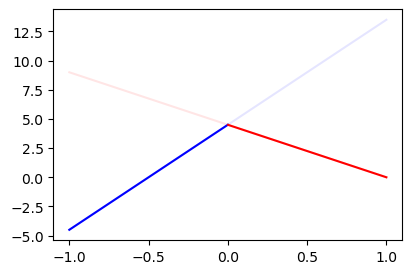

In [ ]:
plt.plot(x, 9*x + 4.5, color = "blue", alpha = 0.1)
plt.plot(x[x < 0], (9*x + 4.5)[x < 0], color = "blue")
plt.plot(x, -4.5*x + 4.5, color = "red", alpha = 0.1)
plt.plot(x[x >= 0], (-4.5*x + 4.5)[x >= 0], color = "red")

# y = x*0 
# y[x<0] = (9*x+4.5)[x<0]
# y[x>0] = (-4.5*x+4.5)[x>0]

# plt.plot(y,'--')
# plt.show()

`# 방법 2` - 렐루 이용

In [19]:
relu = torch.nn.ReLU()

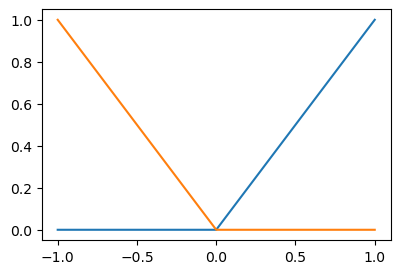

In [21]:
plt.plot(x, relu(x))
plt.plot(x, relu(-x))

> 0을 기준으로 크면 그대로, 작으면 0으로 만드는 함수

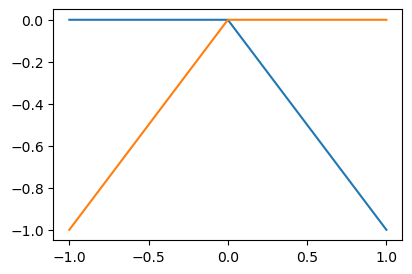

In [23]:
plt.plot(x, -relu(x))
plt.plot(x, -relu(-x))

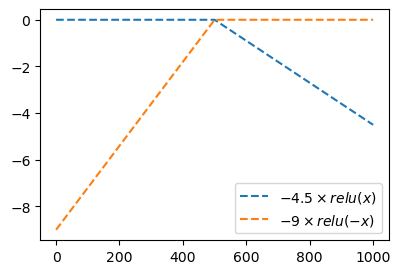

In [24]:
plt.plot(-4.5*relu(x),'--',label=r'$-4.5\times relu(x)$')
plt.plot(-9*relu(-x),'--',label=r'$-9\times relu(-x)$')
plt.legend()

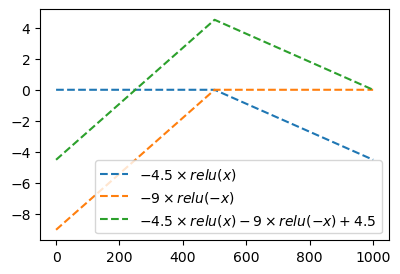

In [ ]:
plt.plot(-4.5*relu(x),'--',label=r'$-4.5\times relu(x)$')
plt.plot(-9*relu(-x),'--',label=r'$-9\times relu(-x)$')
plt.plot(-4.5*relu(x)-9*relu(-x)+4.5,'--',label=r'$-4.5\times relu(x) -9 \times relu(-x)+4.5$') ## 계수 적어주고, 절편 올리고
plt.legend()

`-` 총체적 시각화

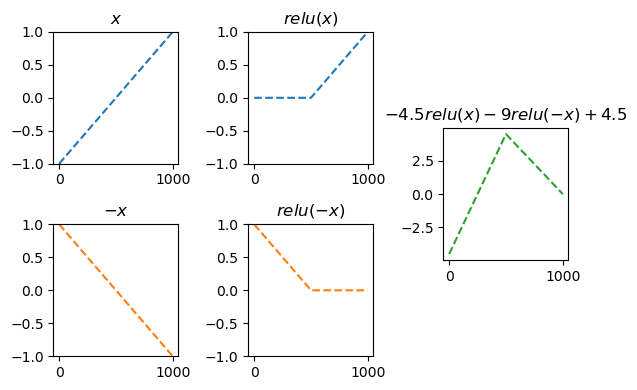

In [26]:
fig = plt.figure(figsize=(6, 4))
spec = fig.add_gridspec(4, 3)
ax1 = fig.add_subplot(spec[:2,0]); ax1.set_title(r'$x$'); ax1.set_ylim(-1,1)
ax2 = fig.add_subplot(spec[2:,0]); ax2.set_title(r'$-x$'); ax2.set_ylim(-1,1)
ax3 = fig.add_subplot(spec[:2,1]); ax3.set_title(r'$relu(x)$'); ax3.set_ylim(-1,1)
ax4 = fig.add_subplot(spec[2:,1]); ax4.set_title(r'$relu(-x)$'); ax4.set_ylim(-1,1)
ax5 = fig.add_subplot(spec[1:3,2]); ax5.set_title(r'$-4.5 relu(x)-9 relu(-x)+4.5$')
#---#
ax1.plot(x,'--',color='C0')
ax2.plot(-x,'--',color='C1')
ax3.plot(relu(x),'--',color='C0')
ax4.plot(relu(-x),'--',color='C1')
ax5.plot(-4.5*relu(x)-9*relu(-x)+4.5,'--',color='C2')
fig.tight_layout()

`# 방법3` – 방법2의 다른구현!

`-` 렐루이용하여 만드는 방법 정리

1.  벡터 x와 relu함수를 준비한다.
2.  u = \[x,-x\] 를 계산한다.
3.  v = \[relu(x), relu(-x)\] 를 계산한다.
4.  y = -4.5 \* relu(x) + 9 \* relu(-x) +4.5 를 계산한다.

`-` `reLU`의 브로드캐스팅 활용

In [ ]:
## 1단계
x, relu

(tensor([[-1.0000],
         [-0.9980],
         [-0.9960],
         ...,
         [ 0.9960],
         [ 0.9980],
         [ 1.0000]]),
 ReLU())

In [ ]:
## 2단계
u = torch.concat([x, -x], axis = 1) ## 말그대로 [x -x]의 500 by 2 행렬
u

tensor([[-1.0000,  1.0000],
        [-0.9980,  0.9980],
        [-0.9960,  0.9960],
        ...,
        [ 0.9960, -0.9960],
        [ 0.9980, -0.9980],
        [ 1.0000, -1.0000]])

In [31]:
## 3단계
v = relu(u) ## 각 열에 렐루를 먹임
v

tensor([[0.0000, 1.0000],
        [0.0000, 0.9980],
        [0.0000, 0.9960],
        ...,
        [0.9960, 0.0000],
        [0.9980, 0.0000],
        [1.0000, 0.0000]])

In [36]:
## 4단계
y = -4.5 * v[:,[0]] - 9.0 * v[:,[1]] +4.5

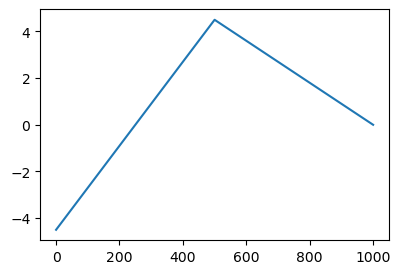

In [38]:
plt.plot(y)

In [ ]:
x = torch.linspace(-1.0, 1.0, 1001).reshape(-1, 1)
relu = torch.nn.ReLU()

`# 방법 4` - 방법 3의 다른 구현

`-` 방법 3의 4단계는 아래와 같이 볼 수 있다.

-   ${\bf v}\begin{bmatrix} -4.5 \\ -9.0 \end{bmatrix} + 4.5 = \begin{bmatrix}
    v_{11} & v_{12}  \\
    v_{21} & v_{22}  \\
    \dots & \dots  \\
    v_{n1} & v_{n2}  \\
    \end{bmatrix}\begin{bmatrix} -4.5 \\ -9.0 \end{bmatrix} + 4.5 =
    \begin{bmatrix}
    -4.5 v_{11} - 9.0 v_{12} + 4.5  \\
    -4.5 v_{21} - 9.0 v_{22} + 4.5  \\
    \dots \\
    -4.5 v_{n1} - 9.0 v_{n2} + 4.5 \\
    \end{bmatrix}$

`-` 위의 수식을 참고하여 매트릭스의 곱 형태로 다시 포현하면 아래와 같다.

In [ ]:
What = torch.tensor([[-4.5], [-9.0]])   ## 열벡터
v @ What + 4.5

`-` 매트릭스 곱 대신에 `torch.nn.Linear()`를 이용

In [39]:
l2 = torch.nn.Linear(
    in_features=2,
    out_features=1 
)

In [40]:
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])

In [41]:
l2(v)

tensor([[-4.5000],
        [-4.4820],
        [-4.4640],
        ...,
        [ 0.0180],
        [ 0.0090],
        [ 0.0000]], grad_fn=<AddmmBackward0>)

`-` 정리

In [42]:
u = torch.concat([x,-x],axis=1)
v = relu(u)
l2 = torch.nn.Linear(
    in_features=2,
    out_features=1 
)
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])
l2(v)

tensor([[-4.5000],
        [-4.4820],
        [-4.4640],
        ...,
        [ 0.0180],
        [ 0.0090],
        [ 0.0000]], grad_fn=<AddmmBackward0>)

`# 방법 5` - 방법3의 또 다른 구현

`-` 사실 방법3의 2단계도 아래와 같이 볼 수 있다.

$$\begin{bmatrix}
x_1 \\
x_2 \\
\dots \\ 
x_n 
\end{bmatrix}\begin{bmatrix} 1 & -1 \end{bmatrix} = \begin{bmatrix} x_1 & -x_1 \\ x_2 & -x_2 \\ \dots & \dots \\ x_n & -x_n \end{bmatrix}$$

In [43]:
l1 = torch.nn.Linear(1,2)
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])

In [44]:
l1(x)

tensor([[-1.0000,  1.0000],
        [-0.9980,  0.9980],
        [-0.9960,  0.9960],
        ...,
        [ 0.9960, -0.9960],
        [ 0.9980, -0.9980],
        [ 1.0000, -1.0000]], grad_fn=<AddmmBackward0>)

`-` 따라서 얘도 `torch.nn`에 포함된 레이어를 이용해서 표현

In [ ]:
l1 = torch.nn.Linear(1,2)
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])
a1 = torch.nn.ReLU()
l2 = torch.nn.Linear(2,1)   ## v가 입력으로 가서 y가 나와야 하는데, v의 차원은 (n, 2) / y의 차원은 (n, 1)
l2.weight.data = torch.tensor([[-4.5,-9.0]])    ## 
l2.bias.data = torch.tensor([4.5])

In [46]:
l2(a1(l1(x))), y

(tensor([[-4.5000],
         [-4.4820],
         [-4.4640],
         ...,
         [ 0.0180],
         [ 0.0090],
         [ 0.0000]], grad_fn=<AddmmBackward0>),
 tensor([[-4.5000],
         [-4.4820],
         [-4.4640],
         ...,
         [ 0.0180],
         [ 0.0090],
         [ 0.0000]]))

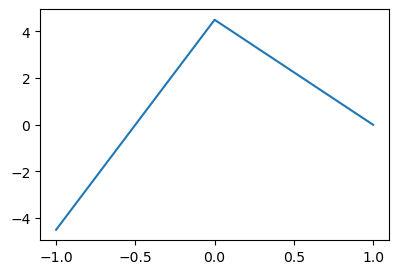

In [49]:
plt.plot(x, y.data)

`# 방법6` – net를 이용

`-` 각각의 layer를 `torch.nn.Sequential()` 로 묶으면 아래와 같이 정리할
수 있다.

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,2),
    torch.nn.ReLU(),
    torch.nn.Linear(2,1)
)
l1,a1,l2 = net
l1.weight.data = torch.tensor([[1.0],[-1.0]])   ## 중간에 꺾일 범위 설정
l1.bias.data = torch.tensor([0.0,0.0])  ## 렐루에 넣기 전 가중치
l2.weight.data = torch.tensor([[-4.5,-9.0]])    ## 렐루를 넣은 뒤 각 범위의 기울기 설정
l2.bias.data = torch.tensor([4.5])  ## 일관적인 절편 표기

In [48]:
net(x),y

(tensor([[-4.5000],
         [-4.4820],
         [-4.4640],
         ...,
         [ 0.0180],
         [ 0.0090],
         [ 0.0000]], grad_fn=<AddmmBackward0>),
 tensor([[-4.5000],
         [-4.4820],
         [-4.4640],
         ...,
         [ 0.0180],
         [ 0.0090],
         [ 0.0000]]))

`#`

> **Note**
>
> ***수식표현***
>
> `(1)` ${\bf X}=\begin{bmatrix} x_1 \\ \dots \\ x_n \end{bmatrix}$
>
> `(2)`
> $l_1({\bf X})={\bf X}{\bf W}^{(1)}\overset{bc}{+} {\boldsymbol b}^{(1)}=\begin{bmatrix} x_1 & -x_1 \\ x_2 & -x_2 \\ \dots & \dots \\ x_n & -x_n\end{bmatrix}$
>
> -   ${\bf W}^{(1)}=\begin{bmatrix} 1 & -1 \end{bmatrix}$
> -   ${\boldsymbol b}^{(1)}=\begin{bmatrix} 0 & 0 \end{bmatrix}$
>
> `(3)`
> $(a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big)=\begin{bmatrix} \text{relu}(x_1) & \text{relu}(-x_1) \\ \text{relu}(x_2) & \text{relu}(-x_2) \\ \dots & \dots \\ \text{relu}(x_n) & \text{relu}(-x_n)\end{bmatrix}$
>
> `(4)`
> $(l_2 \circ a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}$
>
> $\quad=\begin{bmatrix} -4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5 \\ -4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \\ \dots \\ -4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \end{bmatrix}$
>
> -   ${\bf W}^{(2)}=\begin{bmatrix} -4.5 \\ -9 \end{bmatrix}$
> -   $b^{(2)}=4.5$
>
> `(5)`
> $net({\bf X})=(l_2 \circ a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}$
>
> $\quad =\begin{bmatrix} -4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5 \\ -4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \\ \dots \\ -4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \end{bmatrix}$

# 4. 스펙의역설 적합

`-` 다시한번 데이터 정리

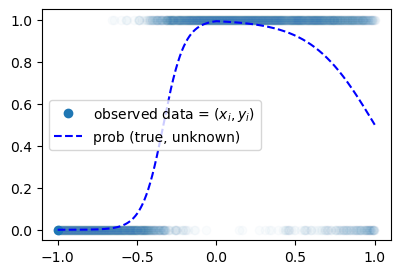

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2025/main/posts/ironyofspec.csv")
x = torch.tensor(df.x).float().reshape(-1,1)    ## float32로 저장된 형식이 아니라 바꿔줌.
y = torch.tensor(df.y).float().reshape(-1,1)
prob = torch.tensor(df.prob).float().reshape(-1,1)  ## true prob
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.legend()

> 언더라잉 : 대충 확률이 적다가 올라갔다가 다시 내려가는 형태

`-` Step1에 대한 생각: 네트워크를 어떻게 만들까? = 아키텍처를 어떻게
만들까? = 모델링

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{{\bf u}^{(1)}} \overset{a_1}{\to} \underset{(n,2)}{{\bf v}^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{{\bf u}^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{{\bf v}^{(2)}}=\underset{(n,1)}{\hat{\bf y}}$$

초기 데이터를 2차원으로 넓힘$[\bf x -x]$ -> 렐루를 먹임 -> 두 열을 합함 -> 시그모이드를 취함

`-` Step1-4

In [69]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1, 2),    ## 1차원의 x를 2차원으로 늘림.
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1),
    torch.nn.Sigmoid()
)

loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())   ## lr도 디폴트로 잘 들어가 있음

for epoc in range(3000) :
    ## step 1
    yhat = net(x)
    ## step 2
    loss = loss_fn(yhat, y)
    ## step 3
    loss.backward()
    ## step 4
    optimizr.step()
    optimizr.zero_grad()

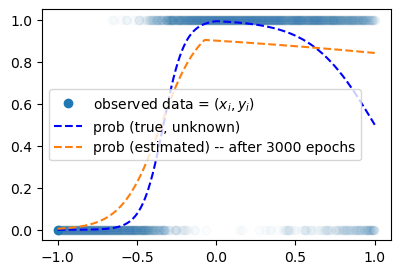

In [70]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data,'--',label="prob (estimated) -- after 3000 epochs")
plt.legend()

In [71]:
for epoc in range(3000):
    ## 
    yhat = net(x)
    ## 
    loss = loss_fn(yhat,y)
    ## 
    loss.backward()
    ## 
    optimizr.step()
    optimizr.zero_grad()

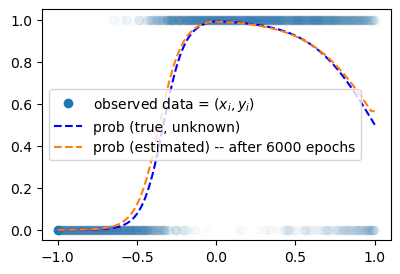

In [72]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data,'--',label="prob (estimated) -- after 6000 epochs")
plt.legend()

`-` 잘 된듯???

> 회귀분석에서와 달리 여러 개의 최적값이 존재할 수 있음. global minimum이 하나만 있는 게 아닐 수 있음.